# Pseudotime analyis

## Import packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Load the data

In [2]:
Path='/home/mgander/pancreas_multiome/data2'
adata=sc.read_h5ad(f'{Path}/Intestinal_epithelial_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 267256 × 21044
    obs: 'sample_id', 'publication', 'sample_name', 'tissue', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch', 'derive', 'detail_tissue', 'time', 'protocol', 'tech_detail', 'molecular', 'gel', 'leiden', 'leiden_10.0', 'level_1', 'level_2', 'level_3', 'level_1_original', 'level_2_original', 'level_3_original', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'day'
    var: 'gene_name', 'ENSG', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'level_1_colors', 'level_2_colors', 'neighbors', 'umap'
    obsm: 'X_scPoli', 'X_umap', 'X_umap_initial', 'X_umap_min', 'X_umap_sc'
    obsp: 'connecti

# Pseudotime analysis

In [3]:
sc.tl.diffmap(adata)

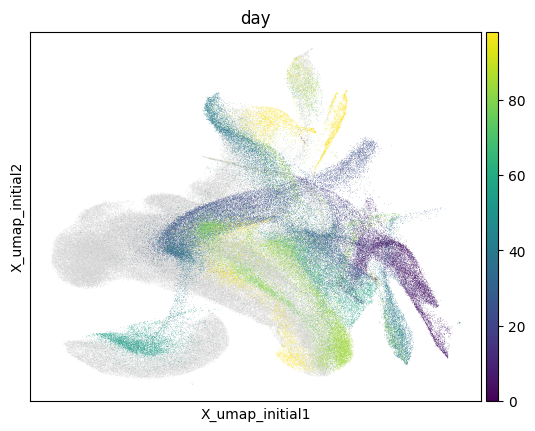

In [4]:
sc.pl.embedding(adata, basis='X_umap_initial', color='day')

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


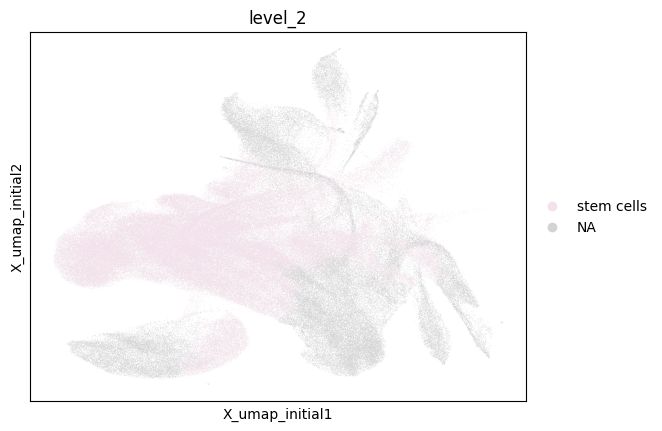

In [5]:
sc.pl.embedding(adata, basis='X_umap_initial', color='level_2', groups=['stem cells'])

To pick a root cell I picked a central stem cell that was close to the ealry time point region.

In [8]:
plt.rcParams['figure.dpi'] = 300

[11677]


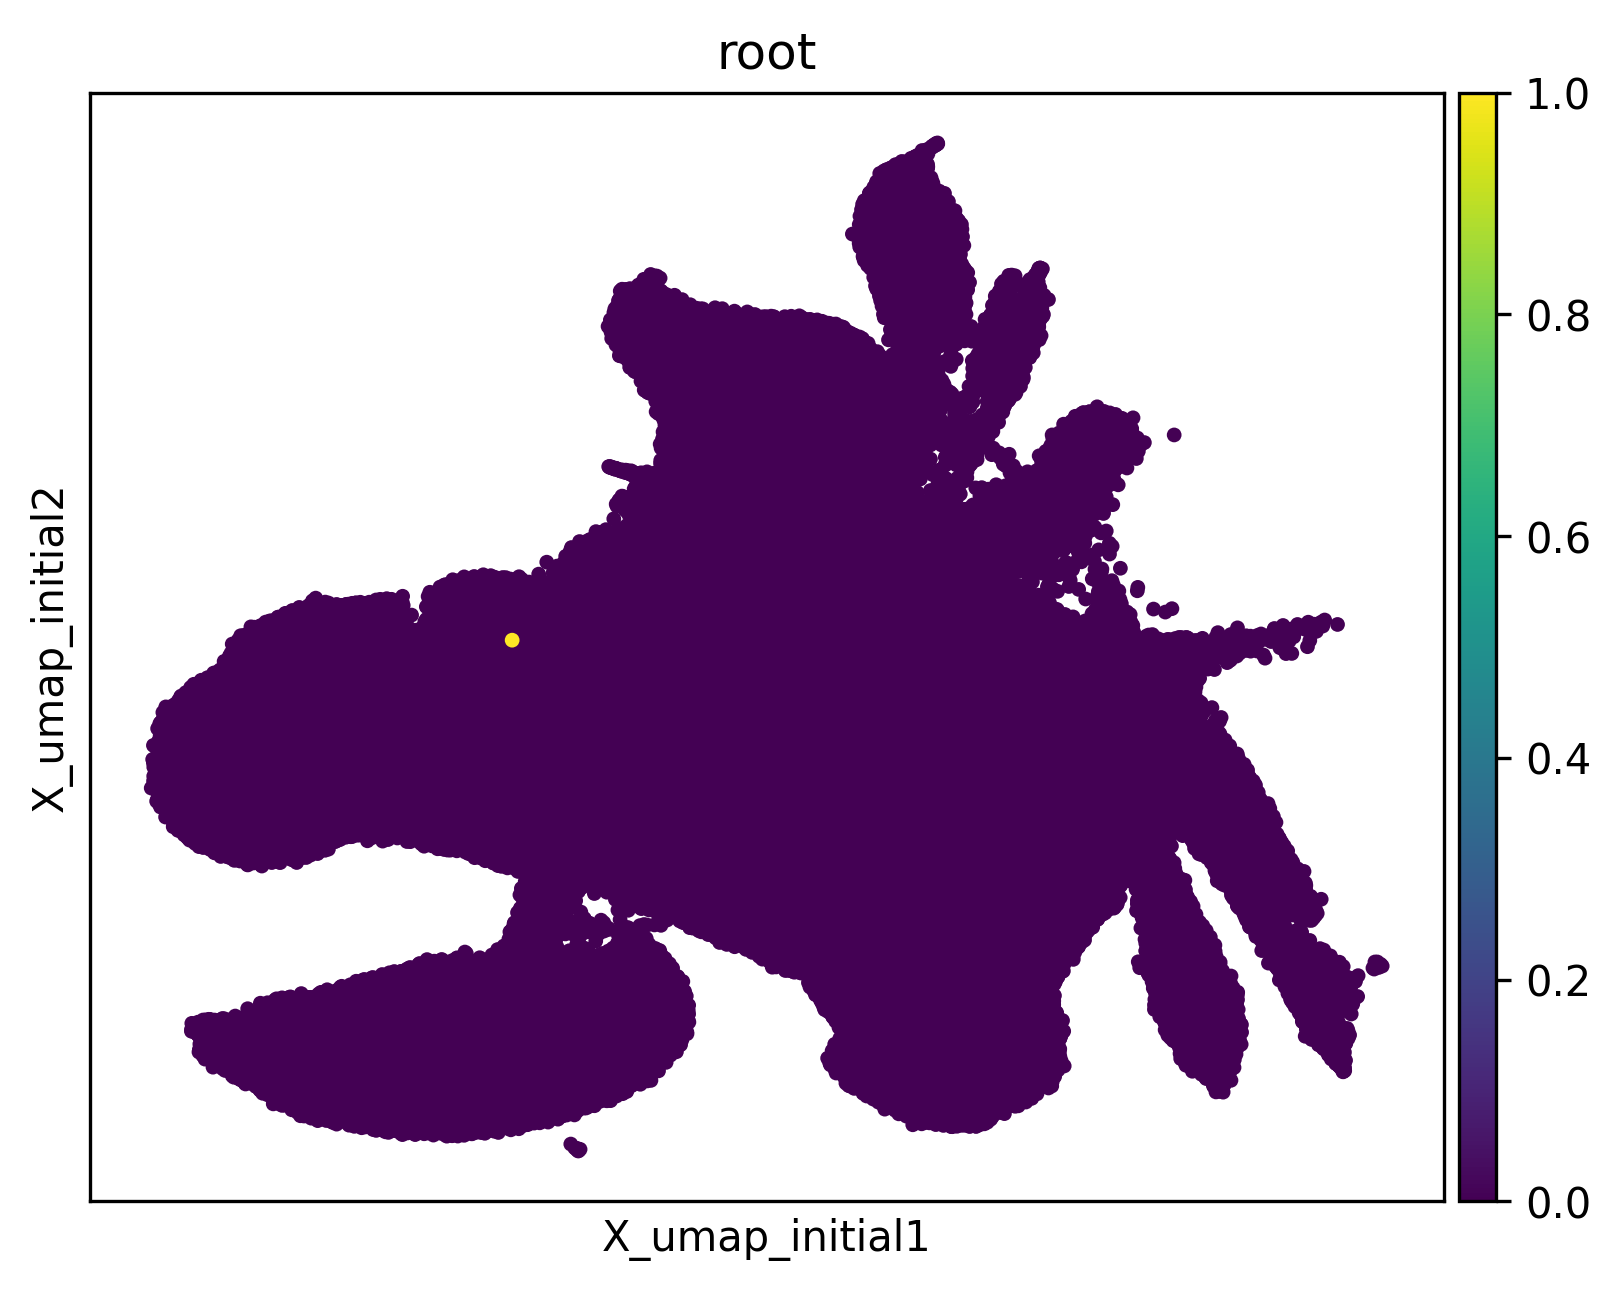

In [9]:
# Pick a root cell
 inds=np.random.choice(list(adata.obs[(adata.obs['level_2']=='stem cells')&(adata.obs['day']==0)].index), n, replace=False)
barcode=np.random.choice(list(adata.obs[(adata.obs['level_2']=='stem cells')].index))
i=np.where(adata.obs.index==barcode)[0]
i=[11677] # Picked cell index

z=np.zeros(len(adata))
z[i]=1
adata.obs['root']=z
sc.pl.embedding(adata, basis='X_umap_initial', color='root', s=50)
adata.uns['iroot'] = i[0]
sc.tl.dpt(adata)

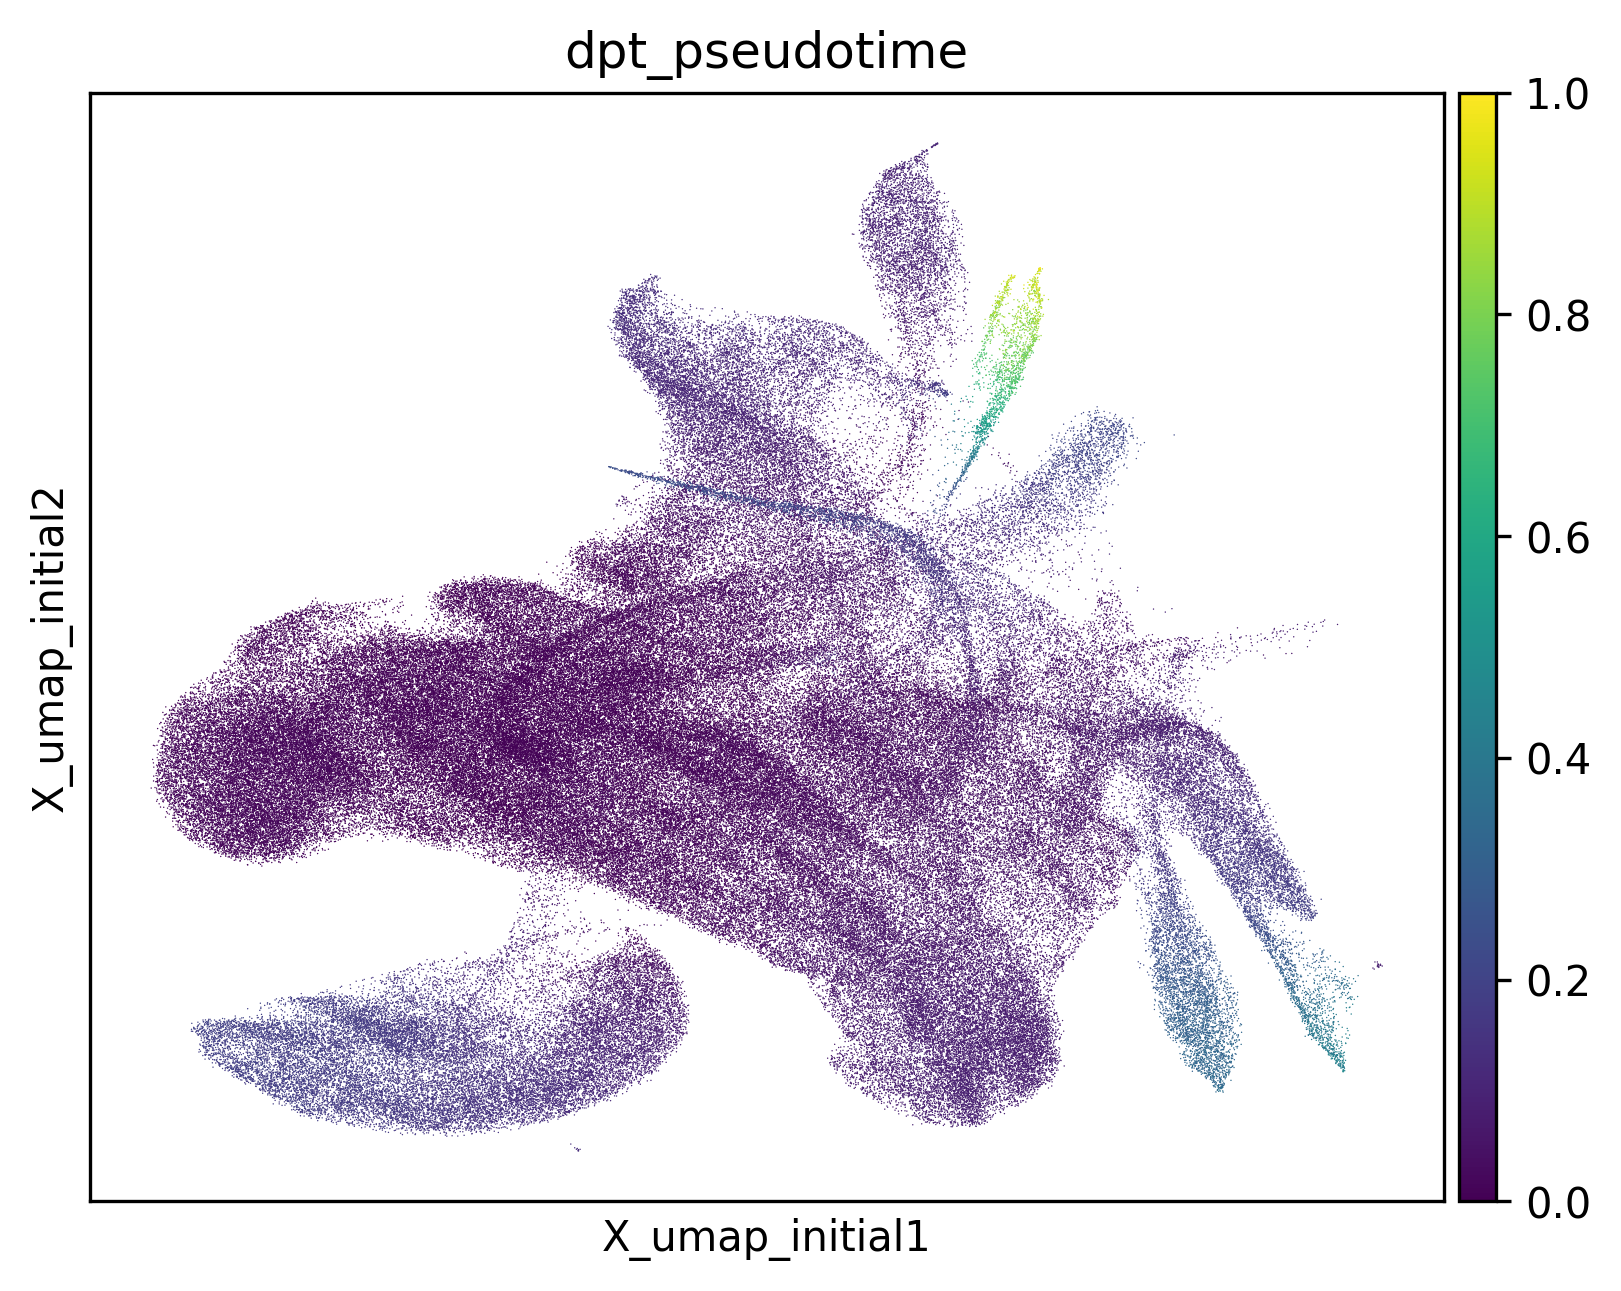

In [10]:
sc.pl.embedding(adata, basis='X_umap_initial', color='dpt_pseudotime', color_map='viridis')

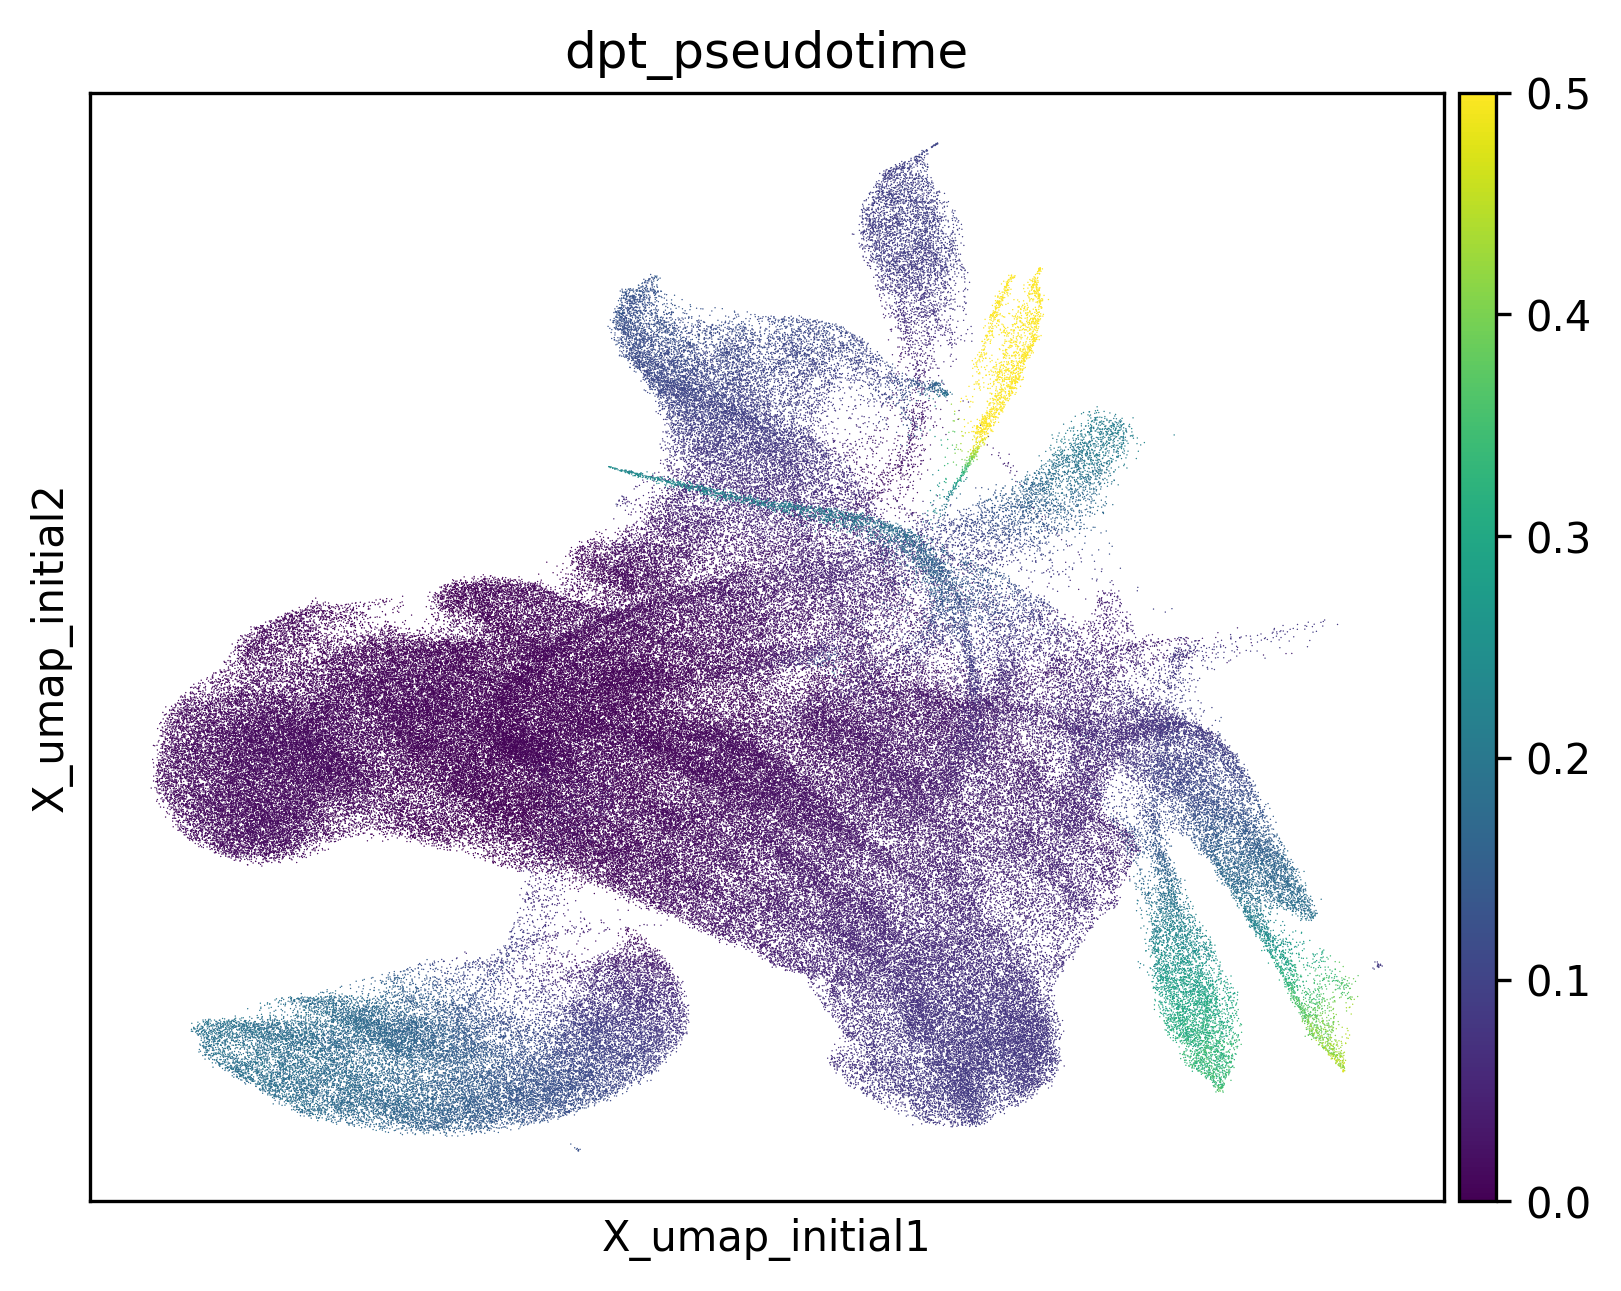

In [11]:
sc.pl.embedding(adata, basis='X_umap_initial', color='dpt_pseudotime', color_map='viridis', vmax=0.5)

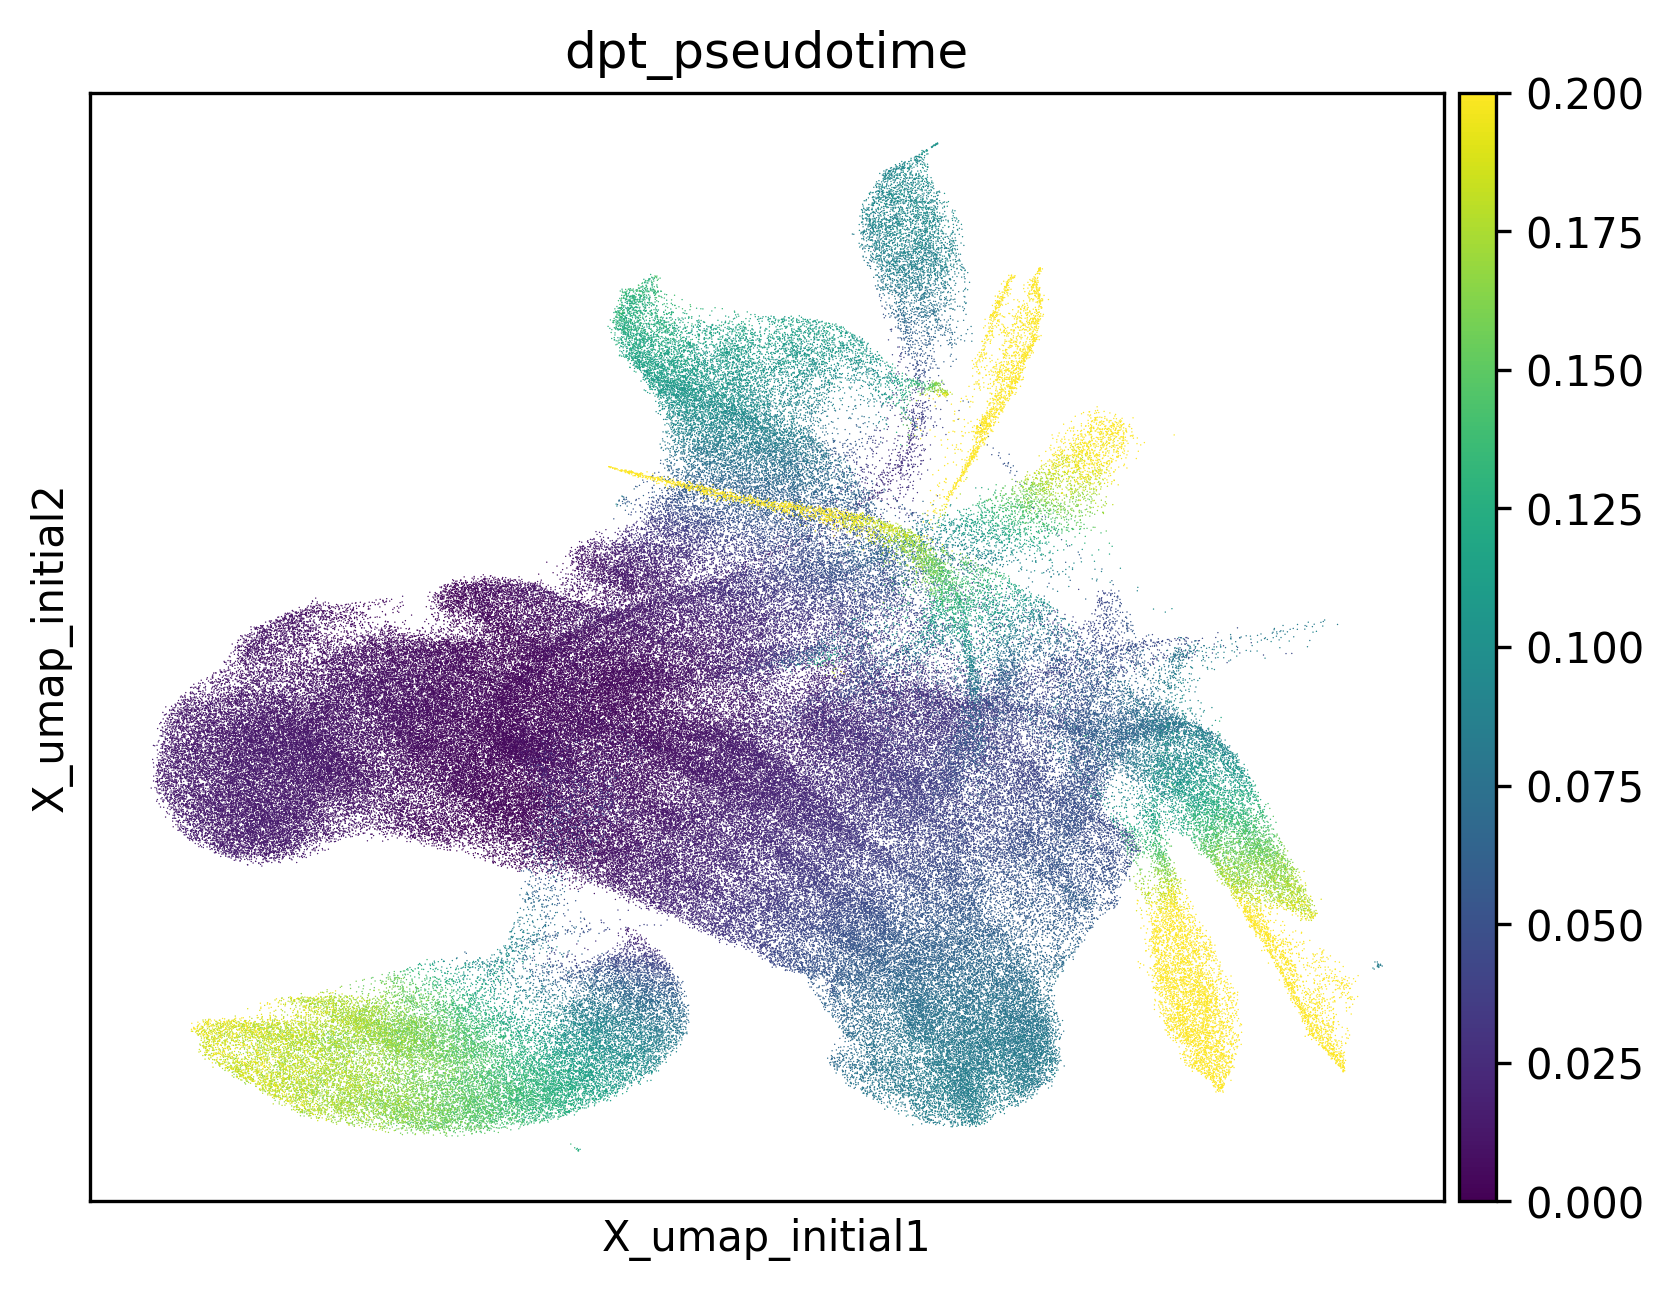

In [12]:
sc.pl.embedding(adata, basis='X_umap_initial', color='dpt_pseudotime', color_map='viridis', vmax=0.2)

# Cellrank analysis

In [13]:
pk = cr.kernels.PseudotimeKernel(adata, time_key='dpt_pseudotime')

In [14]:
pk.compute_transition_matrix()

  0%|          | 0/267256 [00:00<?, ?cell/s]

PseudotimeKernel[n=267256, dnorm=False, scheme='hard', frac_to_keep=0.3]

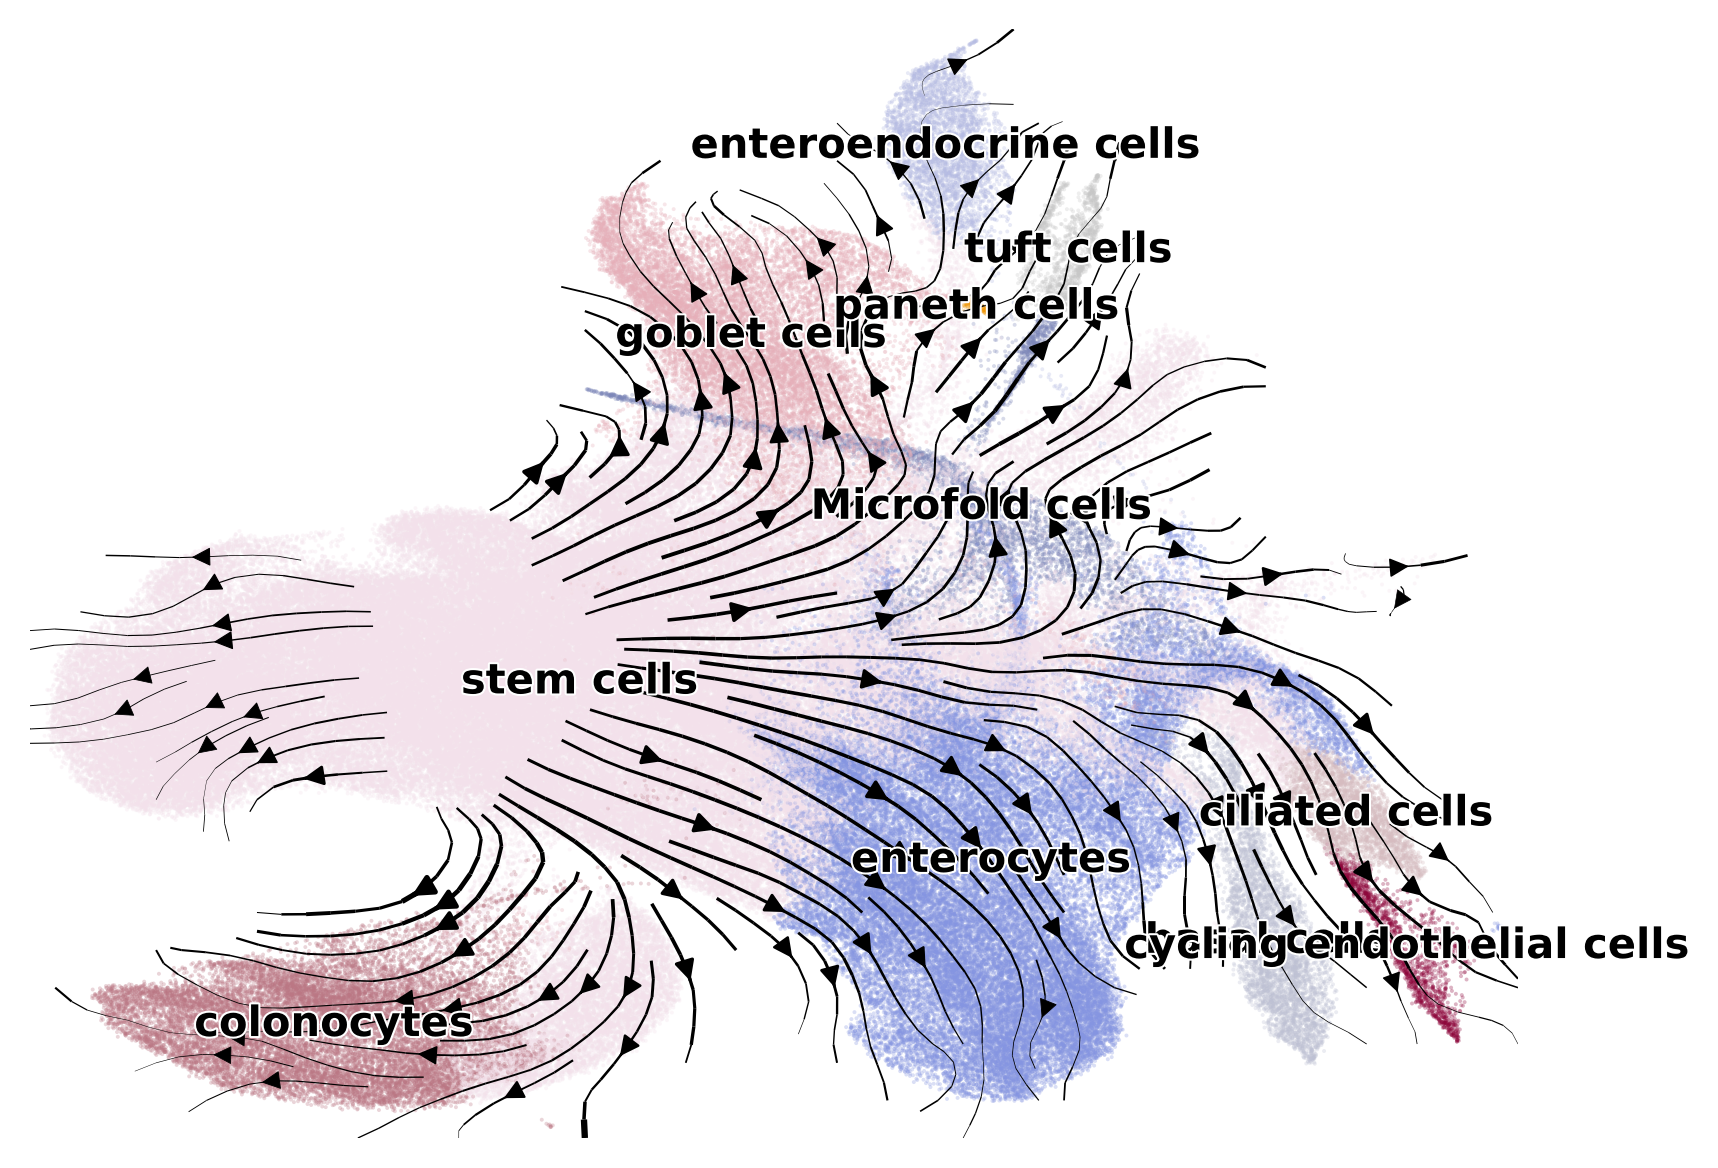

In [15]:
pk.plot_projection(basis='X_umap_initial', color="level_2", recompute=True, 
                   connectivities=adata.obsp['connectivities'], title='')

In [15]:
T=pk.transition_matrix

In [16]:
import pickle
with open(f'{Path}/dpt.pkl', 'wb') as handle:
    pickle.dump(T, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
pseudotime=adata.obs[['dpt_pseudotime']]

In [18]:
pseudotime.to_pickle(f'{Path}/dpt_epithelial.pkl')